In [352]:
# !pip install yfinance
# !pip install tsai

In [353]:
from tsai.basics import *
import yfinance as yf

In [354]:
start = "2004-08-19"
interval = "1d"

# load s&p 500 data
gspc = yf.Ticker("^GSPC")
gspc_data = gspc.history(period="max", interval=interval, start=start)
gspc_data = gspc_data[["Open", "High", "Low", "Close", "Volume"]]

gspc_data

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19 00:00:00-04:00,1095.170044,1095.170044,1086.280029,1091.229980,1249400000
2004-08-20 00:00:00-04:00,1091.229980,1100.260010,1089.569946,1098.349976,1199900000
2004-08-23 00:00:00-04:00,1098.349976,1101.400024,1094.729980,1095.680054,1021900000
2004-08-24 00:00:00-04:00,1095.680054,1100.939941,1092.819946,1096.189941,1092500000
2004-08-25 00:00:00-04:00,1096.189941,1106.290039,1093.239990,1104.959961,1192200000
...,...,...,...,...,...
2024-05-06 00:00:00-04:00,5142.419922,5181.000000,5142.419922,5180.740234,3683250000
2024-05-07 00:00:00-04:00,5187.200195,5200.229980,5178.959961,5187.700195,3987890000
2024-05-08 00:00:00-04:00,5168.979980,5191.950195,5165.859863,5187.669922,3842100000


In [355]:
import yfinance as yf
interval = "1d"
start_date = "2004-08-19"
val_date = "2020-05-01"
test_date = "2022-05-01"
end_date = "2024-05-11"

# Calculate number of intervals
valid_size = 504
test_size = 509

print("Valid Size:", valid_size)
print("Test Size:", test_size)

gspc = yf.Ticker("^GSPC")
gspc_hist = gspc.history(start=start_date, end=end_date, interval=interval)
gspc_hist = gspc_hist.dropna()
gspc_hist = gspc_hist["Close"]
# train_data = gspc_hist.loc[start_date:test_date]
# test_data = gspc_hist.loc[test_date:end_date]

gspc_hist

Valid Size: 504
Test Size: 509


Date
2004-08-19 00:00:00-04:00    1091.229980
2004-08-20 00:00:00-04:00    1098.349976
2004-08-23 00:00:00-04:00    1095.680054
2004-08-24 00:00:00-04:00    1096.189941
2004-08-25 00:00:00-04:00    1104.959961
                                ...     
2024-05-06 00:00:00-04:00    5180.740234
2024-05-07 00:00:00-04:00    5187.700195
2024-05-08 00:00:00-04:00    5187.669922
2024-05-09 00:00:00-04:00    5214.080078
2024-05-10 00:00:00-04:00    5222.680176
Name: Close, Length: 4966, dtype: float64

In [356]:
ts = gspc_data['Close'].values

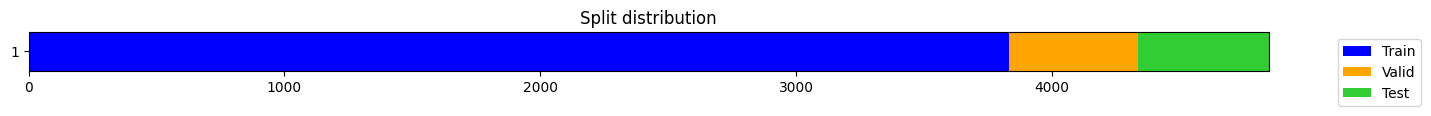

epoch,train_loss,valid_loss,mae,time
0,3459006.500000,16130992.000000,3981.420654,00:01
1,3451512.500000,16046715.000000,3971.204834,00:01
2,3438500.000000,15850653.000000,3947.293701,00:01
3,3433825.750000,15478697.000000,3901.491455,00:01
4,3416411.500000,14863743.000000,3824.399170,00:01
5,3389047.000000,13834716.000000,3691.714111,00:01
6,3347668.250000,13075343.000000,3590.237305,00:01
7,3287278.000000,12466009.000000,3505.702881,00:01
8,3210055.750000,11479490.000000,3365.777344,00:01
9,3120316.000000,8984361.000000,2980.696045,00:01


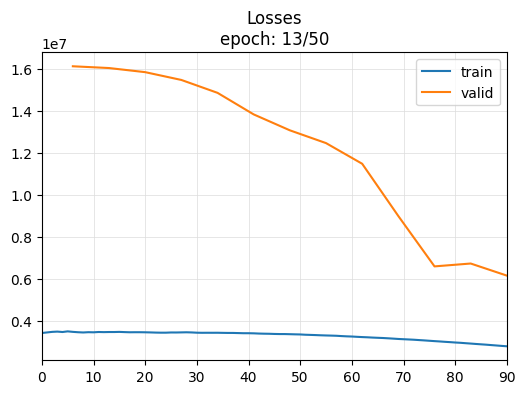

In [ ]:
window_len = 120
X, y = SlidingWindow(window_len, horizon=1)(ts)
splits = TimeSplitter(valid_size=valid_size, test_size=test_size)(y)
tfms = [None, TSForecasting()]
batch_tfms = TSStandardize()
fcst = TSForecaster(X, y, splits=splits, path='models/', tfms=tfms, batch_tfms=batch_tfms, bs=512, 
                    arch="TSTPlus", metrics=mae, cbs=ShowGraph())
fcst.fit_one_cycle(50, 1e-3)
fcst.export("stonk.pkl")

In [ ]:
from tsai.inference import load_learner
def predict(split):
    fcst = load_learner("models/stonk.pkl", cpu=False)
    raw_preds, target, preds = fcst.get_X_preds(X[splits[split]], y[splits[split]])
    
    return pd.DataFrame({"raw_preds": raw_preds.flatten(), "target": target, "preds": preds})

In [ ]:
results = {
    "train": predict(0),
    "val": predict(1),
    "test": predict(2),
}

In [ ]:
results['test']

In [ ]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def MASE(pred, y):
    return float(np.mean(np.abs(pred - y) / np.mean(np.abs(y[1:] - y[:-1]))))

def SMAPE(pred, y):
    return float(200 * np.mean(np.abs(pred - y) / (np.abs(y) + np.abs(pred))))

def MAE(pred, y):
    return float(np.mean(np.abs(pred - y)))

def sharp_ratio(pred, y):
    return float(np.mean((pred - y) / np.std(y)))

def directional_accuracy(Y_actual, Y_predicted):
    actual_changes = np.sign(np.diff(Y_actual))
    predicted_changes = np.sign(np.diff(Y_predicted))
    correct_predictions = np.sum(actual_changes == predicted_changes)
    total_predictions = len(actual_changes)
    directional_accuracy = correct_predictions / total_predictions * 100
    return directional_accuracy

def evaluate(y_true, y_pred, save=False, model_name="model_name"):
    performance = {}
    performance['MSE'] = mean_squared_error(y_true, y_pred)
    performance['MAPE'] = MAPE(y_true, y_pred)
    performance['MASE'] = MASE(y_true, y_pred)
    performance['RMSE'] = math.sqrt(mean_squared_error(y_true, y_pred))
    performance['SMAPE'] = SMAPE(y_true, y_pred)
    performance['MAE'] = MAE(y_true, y_pred)
    performance['SHAPE'] = sharp_ratio(y_true, y_pred)
    performance['Directional Accuracy'] = directional_accuracy(y_true, y_pred)

    if save:
        pd.DataFrame(performance, index=[model_name]).to_csv(f'../performance/{model_name}.csv')
        
    return pd.DataFrame(performance, index=range(1))


In [ ]:
evaluate(results['val']['target'], results['val']['raw_preds'])

In [ ]:
evaluate(results['test']['target'], results['test']['raw_preds'])

In [ ]:
df_out = pd.concat((results['train'], results['val'], results['test']))[["target", "raw_preds"]]

df_out.index = gspc_hist[window_len:].index
df_out

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

In [ ]:
fig = px.line(df_out, labels={'value': "Open", 'created_at': 'Date'})
fig.add_vline(x=val_date, line_width=4, line_dash="dash")
fig.add_vline(x=test_date, line_width=4, line_dash="dash")
# fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [ ]:
def buy_sell_stock(prices,real):
    buy_days = []
    sell_days = []
    current_bought= None
    returns = []
    real_current_bought= None
    real_returns = []
    holding = False  # Flag to indicate if we're holding a stock

    for i in range(1, len(prices)-1):
        if  holding and prices[i] > prices[i - 1] and prices[i] > prices[i + 1]:
            holding = False
            sell_days.append(prices.index[i])
            # Calculating rate of return
            returns.append(((prices[i] - current_bought) / current_bought)+1)
            real_returns.append(((real[i] - real_current_bought) / real_current_bought)+1)

        elif not holding and prices[i] < prices[i - 1] and prices[i] < prices[i + 1]:
            buy_days.append(prices.index[i])
            holding = True
            current_bought = prices[i]
            real_current_bought = real[i]

    returns = np.array(returns)
    expected_return = (np.prod(returns)-1)*100
    max_expected_return = (returns.max()-1)*100

    real_returns = np.array(real_returns)
    real_return = (np.prod(real_returns)-1)*100
    max_real_return =(real_returns.max()-1)*100
    return buy_days, sell_days, expected_return,real_return,max_expected_return,max_real_return,returns,real_returns

In [ ]:
def buy_sell_stock_v2(prices,real):
    buy_days = []
    sell_days = []
    current_bought= None
    returns = []
    real_current_bought= None
    real_returns = []
    holding = False  # Flag to indicate if we're holding a stock

    for i in range(len(prices)-1):
        if  holding and real[i] > prices[i + 1] :
            holding = False
            sell_days.append(prices.index[i])
            # Calculating rate of return
            returns.append(((prices[i] - current_bought) / current_bought)+1)
            real_returns.append(((real[i] - real_current_bought) / real_current_bought)+1)

        elif not holding and real[i] < prices[i + 1]:
            buy_days.append(prices.index[i])
            holding = True
            current_bought = prices[i]
            real_current_bought = real[i]

    returns = np.array(returns)
    expected_return = (np.prod(returns)-1)*100
    max_expected_return = (returns.max()-1)*100

    real_returns = np.array(real_returns)
    real_return = (np.prod(real_returns)-1)*100
    max_real_return =(real_returns.max()-1)*100
    return buy_days, sell_days, expected_return,real_return,max_expected_return,max_real_return,returns,real_returns

In [ ]:
def plot_stock_prices(prices,real, buy_days, sell_days):
    plt.figure(figsize=(30, 10))
    plt.plot(prices.index, prices.values, label='Pred Stock Prices')
    plt.plot(real.index, real.values, label='Real Stock Prices')
    plt.scatter(buy_days, prices.loc[buy_days], color='green', marker='^', label='Buy')
    plt.scatter(sell_days, prices.loc[sell_days], color='red', marker='v', label='Sell')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Prices with Buy/Sell Signals')
    plt.legend()
    # plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
buy_days, sell_days, expected_return, real_return,max_expected_return,max_real_return,returns,real_returns = \
buy_sell_stock(results['test']['raw_preds'], results['test']['target'])
print("expected_return =",expected_return,"%")
print("real_return =",real_return,"%")
print("max_expected_return =",max_expected_return,"%")
print("max_real_return =",max_real_return,"%")
plot_stock_prices(results['test']['raw_preds'], results['test']['target'], buy_days, sell_days)